<a href="https://colab.research.google.com/github/JinXianWen95/PyTorch-bootcamp/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets
How to get our own data into PyTorch?

One of the ways to do so is via: custom datasets.

# Domain Libraries

Depending on the type of data, e.g. video, text, audio, recommendation, we have to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

** Resource: **
https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [ ]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
  print("File helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

Download helper_functions.py


## 1. Get Data

Our dataset is a subset of the Food101 dataset, which has 101 different classes and 1000 images per class (750 training, 250 testing).

It has 3 classes of food and only 10% of the images (~75 training, 25 testing)

When starting the ML projects, it's important to try things on a small scale and the increace it when necessary.

This is to spped up the experimentation



In [ ]:
import requests
import zipfile
from pathlib import Path

data_path = Path("drive/MyDrive/colab_copilot_data/04/data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exists, skipping download")
else:
  print(f"Creating directory {image_path}")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping file")
    zip_ref.extractall(image_path)


drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi already exists, skipping download


## 2. Data preparation and exploration

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its content"""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

walk_through_dir(image_path)

There are 2 directories and 0 images in drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi
There are 3 directories and 0 images in drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/test
There are 0 directories and 25 images in drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/test/pizza
There are 0 directories and 19 images in drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/test/steak
There are 0 directories and 31 images in drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/test/sushi
There are 3 directories and 0 images in drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/train
There are 0 directories and 78 images in drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/train/pizza
There are 0 directories and 75 images in drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/train/steak
There are 0 directories and 72 images in drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/train/sushi


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2.1 Visualizing image

Let's write code to:
1. Get all of the image paths
2. Pick a random image path using Python's `random.choice()`
3. Get the image class name `pathlib.Path.parent.stem`
4. Open the image with Python's PIL
5. Show the image and print metadata

Random image path: drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/test/sushi/1742201.jpg
Image class: sushi
Image height: 512
Image width: 512


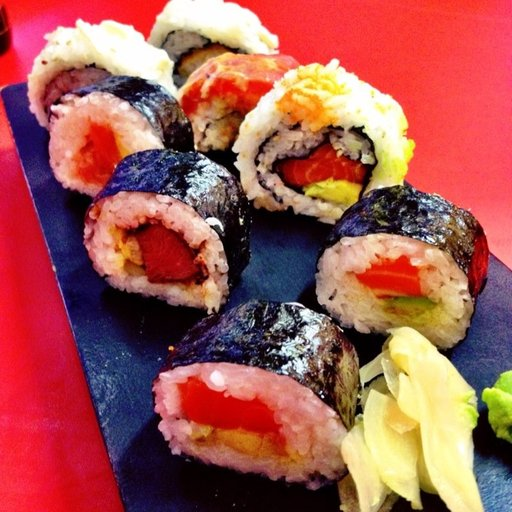

In [ ]:
import random
from PIL import Image

random.seed(42)

# 1. Get all of image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

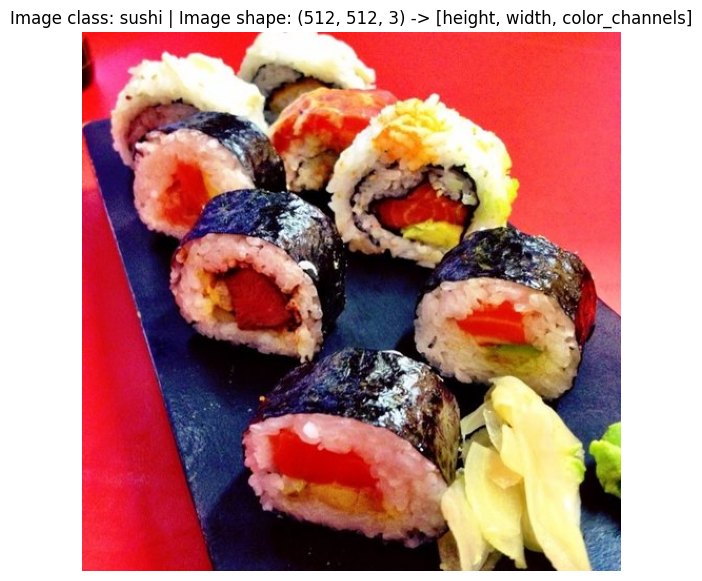

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming Data

Before we can use our image data with PyTorch we need to:

* Turn it into tensors.
* Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on.

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as `torchvision.transforms` for preparing our data.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforms

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for data augmentation

In [ ]:
# Write transform for image
data_transform = transforms.Compose([ # also nn.Sequential can be used
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance.
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

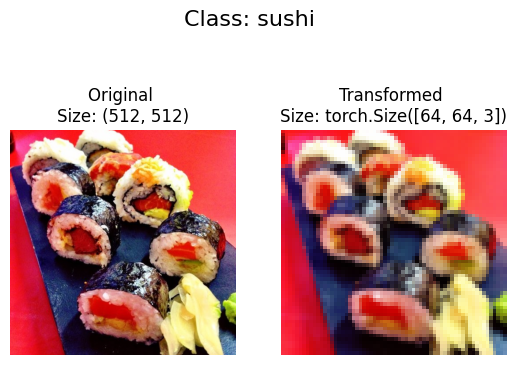

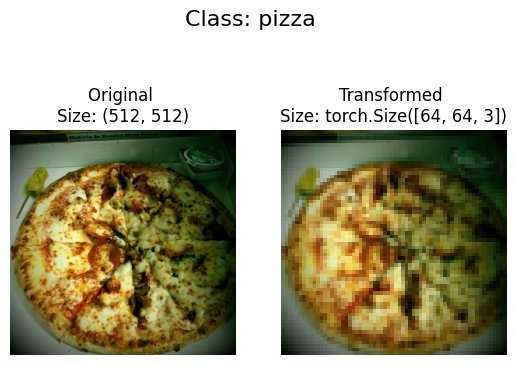

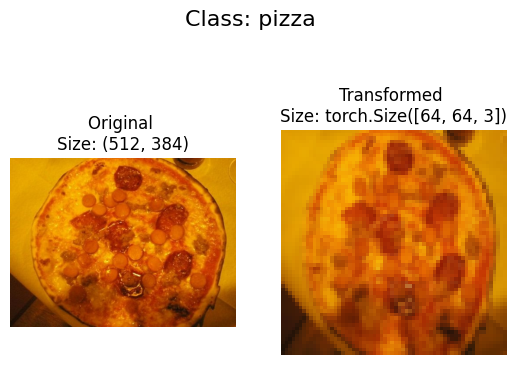

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

## 4. Loading image data

### 4.1 Using ImageFolder

We can loading image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # for data
                                  target_transform=None) # for label

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform, # for data
                                  target_transform=None)

print(train_data, test_data)

class_names = train_data.classes
print(class_names)
class_dict = train_data.class_to_idx
print(class_dict)
print(len(train_data), len(test_data))

Dataset ImageFolder
    Number of datapoints: 225
    Root location: drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ) Dataset ImageFolder
    Number of datapoints: 75
    Root location: drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
225 75


Image label: pizza
Image label datatype: <class 'int'>
Image tensor shape: torch.Size([3, 64, 64])
Image tensor datatype: torch.float32


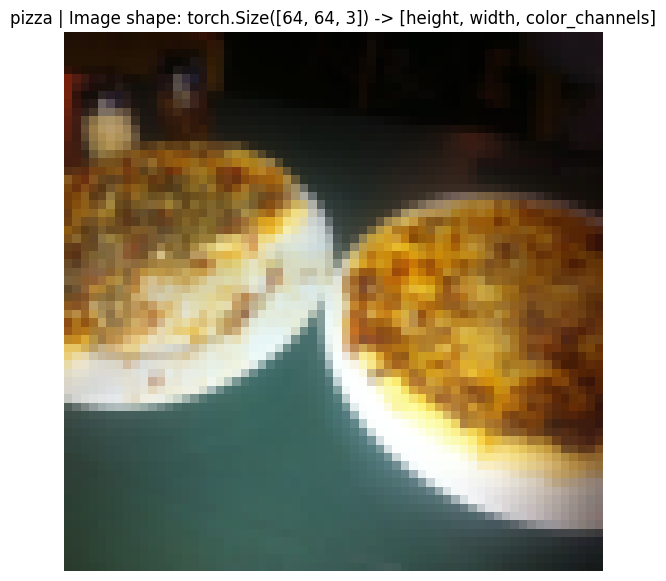

In [ ]:
# Get a single image from data
img, label = train_data[0][0], train_data[0][1]

print(f'Image label: {class_names[label]}')
print(f'Image label datatype: {type(label)}')
print(f'Image tensor shape: {img.shape}')
print(f'Image tensor datatype: {img.dtype}')

img_permute = img.permute(1, 2, 0)

plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.title(f"{class_names[label]} | Image shape: {img_permute.shape} -> [height, width, color_channels]")
plt.axis(False);

#### 4.1.1 Turn loaded images into `DataLoader`

In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

print(len(train_dataloader), len(test_dataloader)) # same size of data since batch size is 1

225 75


In [ ]:
img, label = next(iter(train_dataloader))

print(f'Image label: {class_names[label]}')
print(f'Image label datatype: {type(label)}')
print(f'Image tensor shape: {img.shape}')
print(f'Image tensor datatype: {img.dtype}')

Image label: steak
Image label datatype: <class 'torch.Tensor'>
Image tensor shape: torch.Size([1, 3, 64, 64])
Image tensor datatype: torch.float32


### 4.2 Using a Custom `Dataset`

Want to be able to:
1. Load images from file
2. Get class names from the Dataset
3. Get callses as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though we could create `Dataset` out of almost anything, it might not work
* We need more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, often subclass `Dataset`

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

#### 4.2.1 Creating a helper function to get class names

1. Get the class names using `os.scandir`
2. Raise an error if the class names aren't found
3. Turn the class names into a dict and a list

In [ ]:
# Setup path for the target directorcy
target_dir = train_dir
print(f'Target dir: {target_dir}')

class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
print(class_names_found)

Target dir: drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi/train
['pizza', 'steak', 'sushi']


In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}. Check file structure")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 4.2.2 Create a custom `Dataset` to replicate `ImageFolder`

We need to:
1. Subclass `torch.utils.data.Dataset`
2. Init the subclass with a target directory as well as a transform
3. Create several attributes:
  * paths - paths of the images
  * transform - the transform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer values
4. Create a function to `load_image()`
5. Overwirte the `__len()__` method to return the length of the dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [ ]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self, targ_dir: str, transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    """Opens an image via a path and return it"""
    return Image.open(self.paths[index])

  def __len__(self) -> int:
    """Return the total number of samples"""
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    """Return one sample of data (X, y)"""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format "data_path/class_name/image/jpg"
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)

    return img, class_idx

In [ ]:
# Create a transform
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=train_transform)

print(len(train_data_custom), len(test_data_custom))
print(train_data_custom.classes)
print(train_data_custom.class_to_idx)
print(train_data_custom.classes==test_data_custom.classes)

img, label = train_data_custom[0][0], train_data_custom[0][1]


225 75
['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}
True


#### 4.2.3 Create a function to dislay random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize
2. To prevent the disply getting out of hand, let's cap the number of images to see at 10
3. Set the random seed
4. Get a list of random sample indexes from target dataset
5. Plot the images

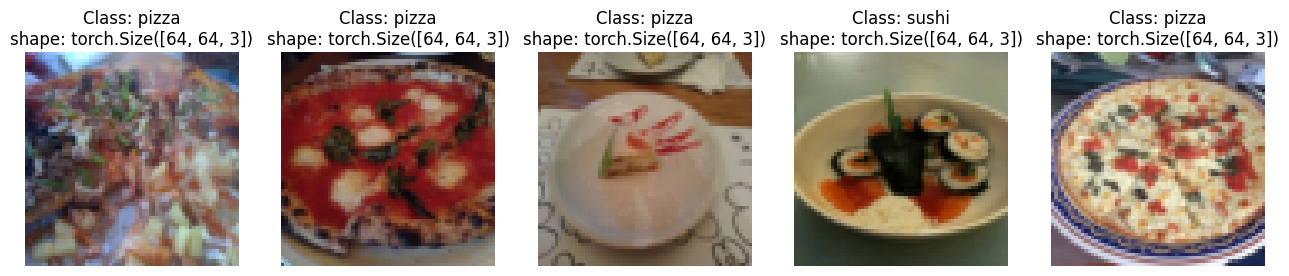

In [ ]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purpose, n shouldn't be larger than 10, setting to 10 and removing shape display")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  fig = plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, target_label = dataset[targ_sample][0], dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1, 2, 0) #HWC format

    fig.add_subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    if classes:
      title = f'Class: {classes[target_label]}'
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"

    plt.title(title)
    plt.axis(False)

display_random_images(train_data, train_data.classes, 5, True, None)

For display purpose, n shouldn't be larger than 10, setting to 10 and removing shape display


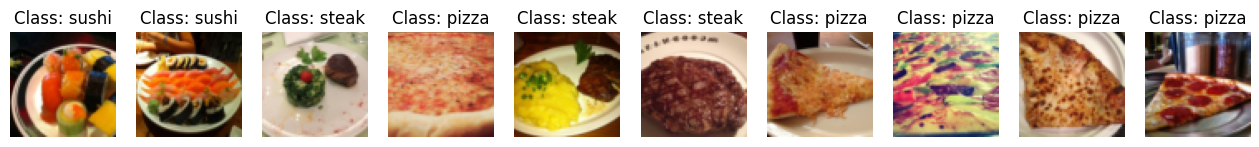

In [ ]:
display_random_images(train_data_custom, train_data.classes, 20, True, None)

#### 4.2.4 Turn custom dataset to DataLoader

In [ ]:
BATCH_SIZE = 1
train_custom_dataloader = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_custom_dataloader = DataLoader(dataset=test_data_custom,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

print(len(test_custom_dataloader), len(train_custom_dataloader)) # same size of data since batch size is 1
img, label = next(iter(train_custom_dataloader))

print(f'Image label: {class_names[label]}')
print(f'Image label datatype: {type(label)}')
print(f'Image tensor shape: {img.shape}')
print(f'Image tensor datatype: {img.dtype}')

75 225
Image label: steak
Image label datatype: <class 'torch.Tensor'>
Image tensor shape: torch.Size([1, 3, 64, 64])
Image tensor datatype: torch.float32


## 5. Data Augmentation

Data augmentation is the process of artificially adding diversity the the training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to unseen data, preveting overfitting.

Let's check one particular type of data augmentation used to train PyTorch vision models to state of art levls.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # from 0 (no-effect) to 30
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

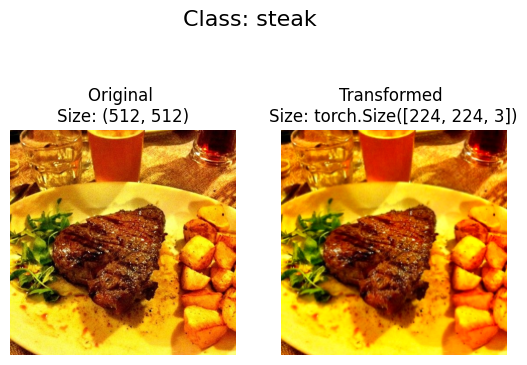

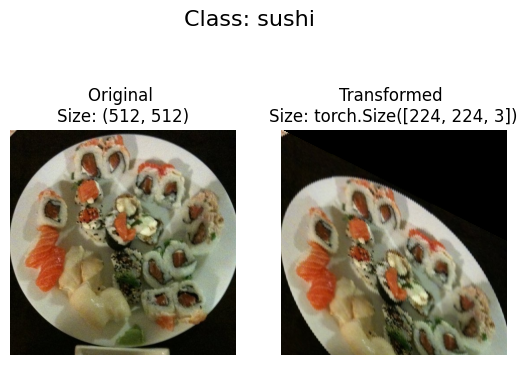

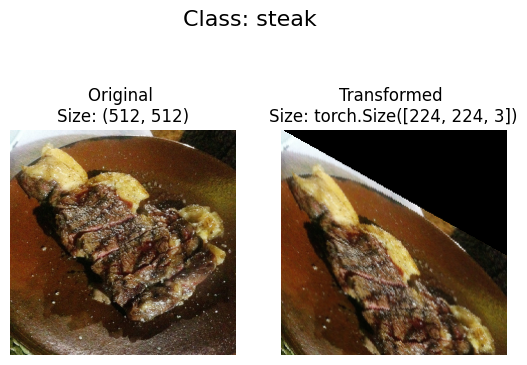

In [ ]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 6. Model 0: TinyVGG without data augmentation

### 6.1 Creating transforms and loading data for Model 0

In [ ]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data_simple = datasets.ImageFolder(root=train_dir,
                                  transform=simple_transform, # for data
                                  target_transform=None) # for label

test_data_simple = datasets.ImageFolder(root=test_dir,
                                  transform=simple_transform, # for data
                                  target_transform=None)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

### 6.2 Create TinyVGG model class

In [ ]:
# Create a convolutional neural network
class TinyVGG(nn.Module):
  """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, # 2d because we have height and width
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13, # Pass a tensor through the cnn and use print to find out the shape of 7*7
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f'Output shape of cov_block_1: {x.shape}')
    x = self.conv_block_2(x)
    # print(f'Output shape of cov_block_2: {x.shape}')
    x = self.classifier(x)
    # print(f'Output shape of classifier: {x.shape}')
    return x


model_0 = TinyVGG(
    input_shape=3, # number of color channel
    hidden_units=64,
    output_shape=len(train_data_simple.classes)
)

### 6.3 Try a forward pass on a single image

In [ ]:
image_batch, label_batch = next(iter(train_dataloader_simple))

y = model_0(image_batch)
print(len(image_batch))
print(y.shape)

32
torch.Size([32, 3])


### 6.4 Use `torchinfo` to get an idea of the shapes going through the model

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo

from torchinfo import summary

summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 64, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 64, 62, 62]           1,792
│    └─ReLU: 2-2                         [1, 64, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 64, 60, 60]           36,928
│    └─ReLU: 2-4                         [1, 64, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 64, 30, 30]           --
├─Sequential: 1-2                        [1, 64, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 64, 28, 28]           36,928
│    └─ReLU: 2-7                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 64, 26, 26]           36,928
│    └─ReLU: 2-9                         [1, 64, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 64, 13, 13]           --


### 6.5 Create train and test loops functions

In [ ]:
from helper_functions import accuracy_fn

def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device
    ):
  """Performs a training loop with model trying to learn on data_loader"""

  model.to(device)
  model.train()

  ### Training
  train_loss, train_acc = 0, 0
  # Add a loop to loop though the training batches
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  # Divide total train loss and accuracy by length of train dataloader
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc



In [ ]:
def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = device
):
  """Performs a test loop stesp on model over dataloader"""
  test_loss, test_acc = 0, 0
  model.eval()
  model.to(device)
  with torch.inference_mode():
    for (X_test, y_test) in dataloader:
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass
      test_pred = model(X_test)

      # Loss and accuracy
      test_loss += loss_fn(test_pred, y_test)
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Test loss average per batch
    test_loss /= len(dataloader)

    # Test accuracy average per batch
    test_acc /= len(dataloader)

  # Print out what's happening
  return test_loss, test_acc

In [ ]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    epochs: int = 5,
    device: torch.device = device
):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Create training and test loop
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(
      model=model,
      dataloader=train_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      accuracy_fn=accuracy_fn,
      device=device
    )

    test_loss, test_acc = test_step(
      model=model,
      dataloader=test_dataloader,
      loss_fn=loss_fn,
      accuracy_fn=accuracy_fn,
      device=device
    )

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')

    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)


  return results

### 6.6 Train and evaluate model 0

In [ ]:
torch.manual_seed(42)

NUM_EPOCHS = 5

start_time = timer()
model_0_results = train(
    model=model_0,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer= torch.optim.Adam(model_0.parameters(),
                                lr=0.001),
    accuracy_fn=accuracy_fn,
    epochs=NUM_EPOCHS,
    device=device
)
end_time = timer()

print(f'Total training time: {end_time-start_time:.3f} seconds')
print(model_0_results)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1081 | Train acc: 20.31% | Test loss: 1.0993, Test acc: 27.08%
Epoch: 1 | Train loss: 1.0725 | Train acc: 44.14% | Test loss: 1.1314, Test acc: 27.08%
Epoch: 2 | Train loss: 1.0900 | Train acc: 35.94% | Test loss: 1.0903, Test acc: 27.08%
Epoch: 3 | Train loss: 1.0128 | Train acc: 47.27% | Test loss: 1.0580, Test acc: 33.24%
Epoch: 4 | Train loss: 0.8705 | Train acc: 65.62% | Test loss: 1.0684, Test acc: 42.33%
Total training time: 48.081 seconds
{'train_loss': [1.1081321239471436, 1.0724537372589111, 1.090029239654541, 1.0127888917922974, 0.8704575896263123], 'train_acc': [20.3125, 44.140625, 35.9375, 47.265625, 65.625], 'test_loss': [1.099328637123108, 1.1313828229904175, 1.0903122425079346, 1.0580289363861084, 1.0684478282928467], 'test_acc': [27.083333333333332, 27.083333333333332, 27.083333333333332, 33.23863636363637, 42.32954545454546]}


### 6.7 Plot the loss curves of model 0

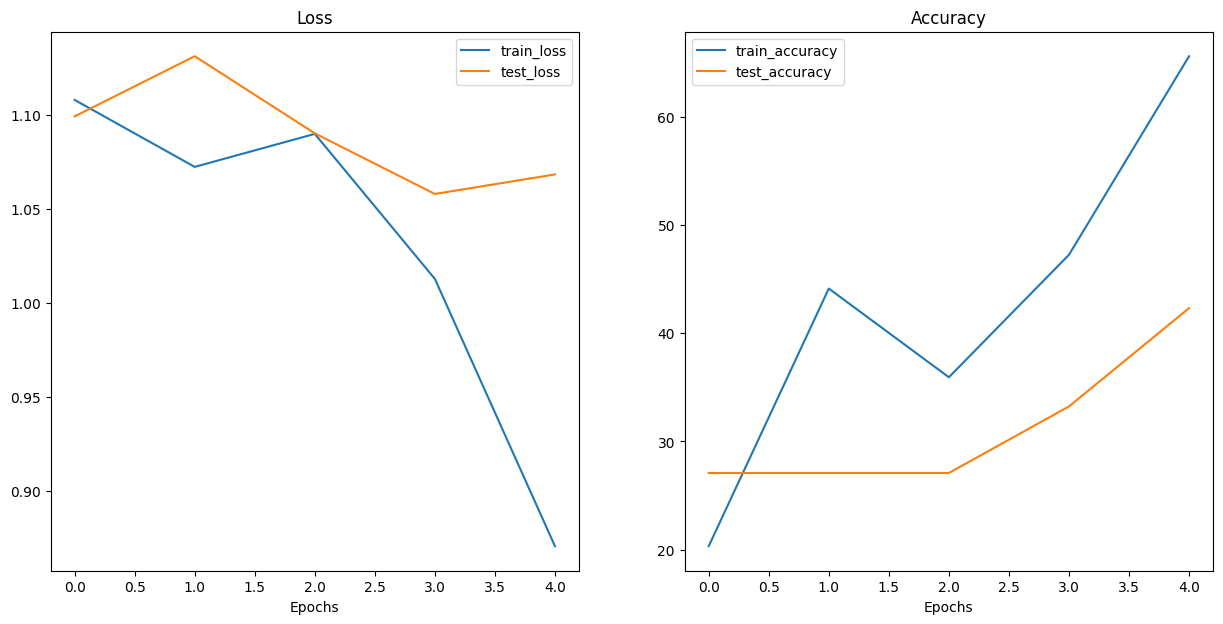

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary"""
  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

plot_loss_curves(model_0_results)

## 7. What should an ideal loss curve look like?

A loss curve is one of the most helpful ways to troubleshot models.
https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

## 8. Model 1: TinyVGG with Data Augmentation

### 8.1 Create transform with data augmentation and load data

In [ ]:
train_trivial_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                  transform=train_trivial_transform, # for data
                                  target_transform=None) # for label

test_data_simple = datasets.ImageFolder(root=test_dir,
                                  transform=test_simple_transform, # for data
                                  target_transform=None)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_augmented = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

### 8.2 Construct and train model 1

In [ ]:
model_1 = TinyVGG(
    input_shape=3, # number of color channel
    hidden_units=64,
    output_shape=len(train_data_augmented.classes)
)

torch.manual_seed(42)

NUM_EPOCHS = 10

start_time = timer()
model_1_results = train(
    model=model_1,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_simple,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer= torch.optim.Adam(model_1.parameters(),
                                lr=0.001),
    accuracy_fn=accuracy_fn,
    epochs=NUM_EPOCHS,
    device=device
)
end_time = timer()

print(f'Total training time: {end_time-start_time:.3f} seconds')
print(model_1_results)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1079 | Train acc: 37.50% | Test loss: 1.1005, Test acc: 26.04%
Epoch: 1 | Train loss: 1.0702 | Train acc: 42.97% | Test loss: 1.1368, Test acc: 26.04%
Epoch: 2 | Train loss: 1.0967 | Train acc: 33.20% | Test loss: 1.0998, Test acc: 30.21%
Epoch: 3 | Train loss: 1.0340 | Train acc: 44.92% | Test loss: 1.0251, Test acc: 30.11%
Epoch: 4 | Train loss: 0.8492 | Train acc: 65.62% | Test loss: 1.2464, Test acc: 35.32%
Epoch: 5 | Train loss: 0.9677 | Train acc: 50.00% | Test loss: 1.0855, Test acc: 48.48%
Epoch: 6 | Train loss: 0.8459 | Train acc: 62.89% | Test loss: 1.1204, Test acc: 38.35%
Epoch: 7 | Train loss: 0.8696 | Train acc: 65.62% | Test loss: 1.0359, Test acc: 39.30%
Epoch: 8 | Train loss: 0.8776 | Train acc: 53.52% | Test loss: 1.0617, Test acc: 48.48%
Epoch: 9 | Train loss: 0.8749 | Train acc: 46.09% | Test loss: 0.9477, Test acc: 53.41%
Total training time: 18.915 seconds
{'train_loss': [1.1078609228134155, 1.0701723098754883, 1.0967490673065186, 1.033989

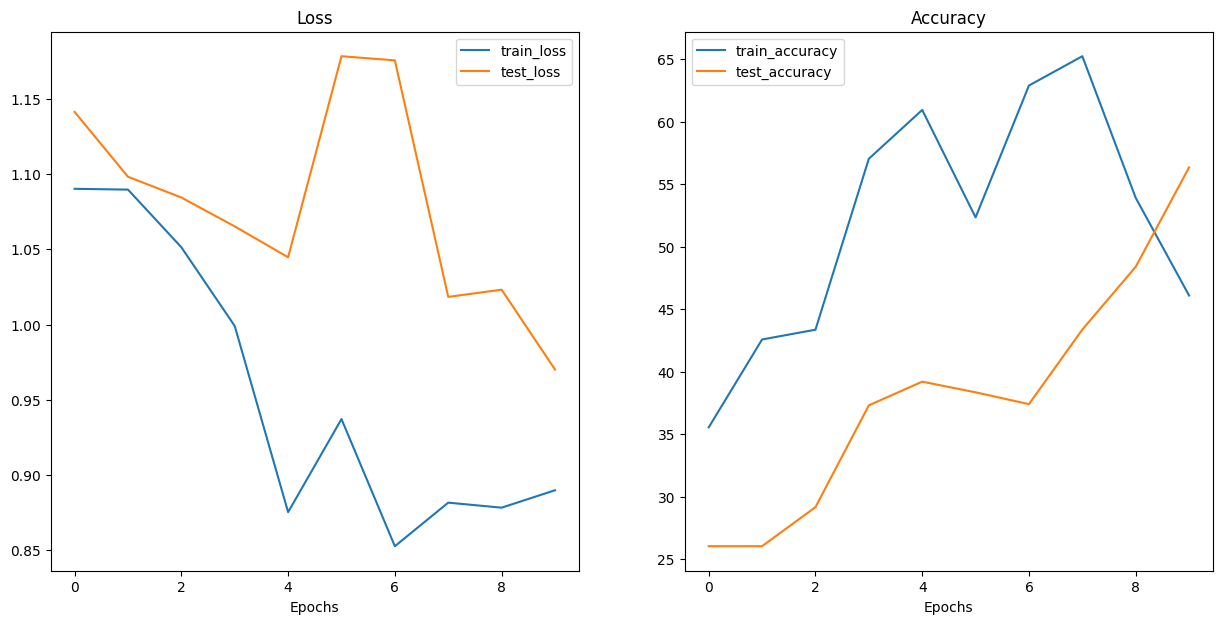

In [ ]:
plot_loss_curves(model_1_results)

## 9. Compare model results

After evaluating the modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do it:
1. Hard coding
2. PyTorch + Tensorboard
3. Weights & biases https://wandb.ai/site/experiment-tracking/
4. MLFlow

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)[:5]

print(model_0_df)
print(model_1_df)

   train_loss  train_acc  test_loss   test_acc
0    1.108132  20.312500   1.099329  27.083333
1    1.072454  44.140625   1.131383  27.083333
2    1.090029  35.937500   1.090312  27.083333
3    1.012789  47.265625   1.058029  33.238636
4    0.870458  65.625000   1.068448  42.329545
   train_loss  train_acc  test_loss   test_acc
0    1.090294  35.546875   1.141462  26.041667
1    1.089752  42.578125   1.098309  26.041667
2    1.051391  43.359375   1.084502  29.166667
3    0.999010  57.031250   1.065283  37.310606
4    0.875144  60.937500   1.044731  39.204545


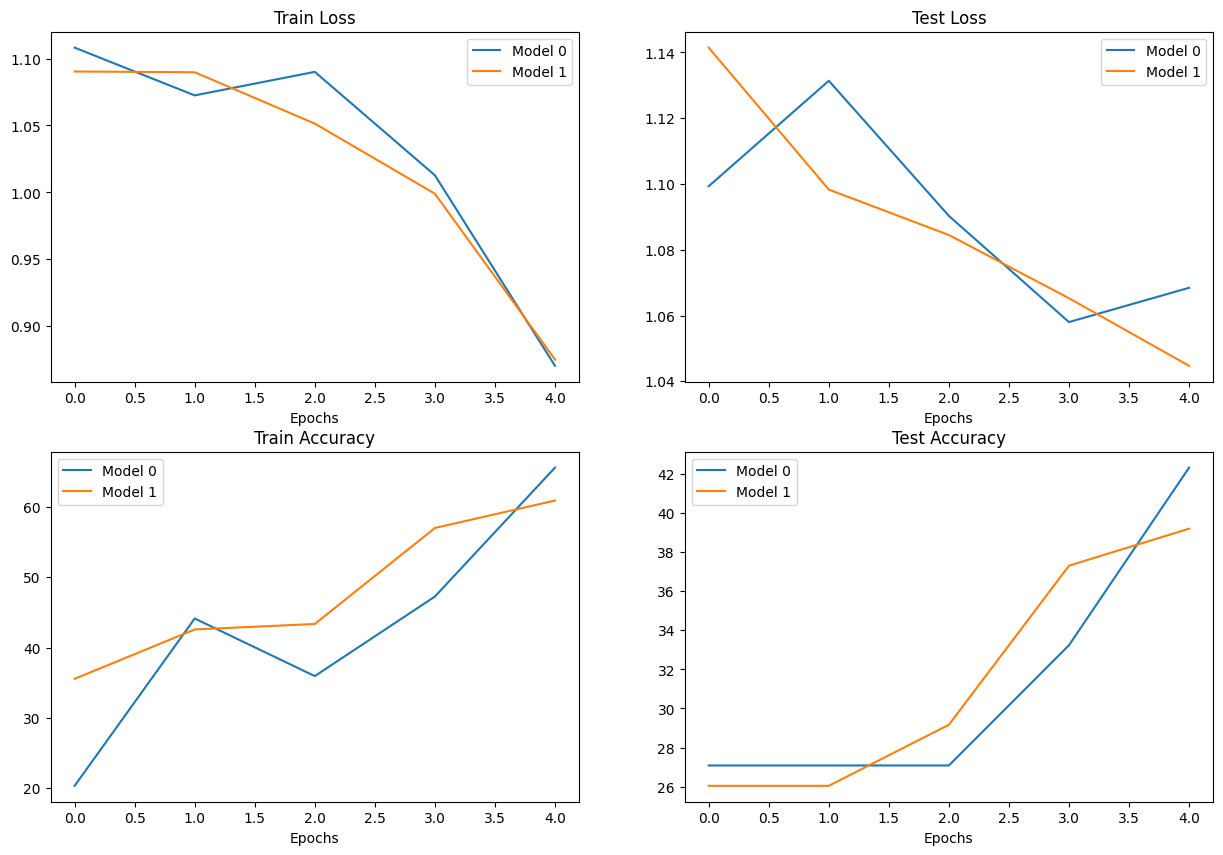

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 9 Making a prediction on a custom image

In [ ]:
# Download custom image
import requests
import zipfile
from pathlib import Path

data_path = Path("drive/MyDrive/colab_copilot_data/04/data/")
custom_image_path = data_path / "04-pizza.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print("Downloading custom image...")
    f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

drive/MyDrive/colab_copilot_data/04/data/04-pizza.jpeg already exists, skipping download.


### 9.1 Loading in a custom image with PyTorch

We have to make sure the custom image is in the same format as the data the model was trained on

* In tensor form with datatype
* Of shape 64x64x3
* of the right device

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape:
 torch.Size([3, 4032, 3024])
Custom image dat

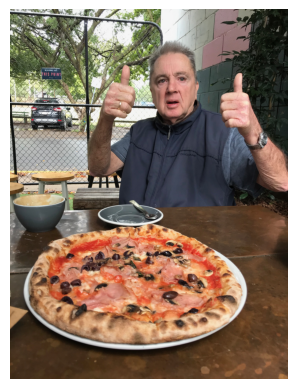

In [ ]:
import torchvision
import matplotlib.pyplot as plt

custom_image_uint8 = torchvision.io.read_image(custom_image_path)
plt.imshow(custom_image_uint8.permute(1,2,0))
plt.axis(False)

print(f'Custom image tensor:\n {custom_image_uint8}')
print(f'Custom image shape:\n {custom_image_uint8.shape}')
print(f'Custom image datatype:\n {custom_image_uint8.dtype}')

### 11.2 Making a prediction on a custom image with the model

torch.Size([3, 64, 64])
torch.float32


(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

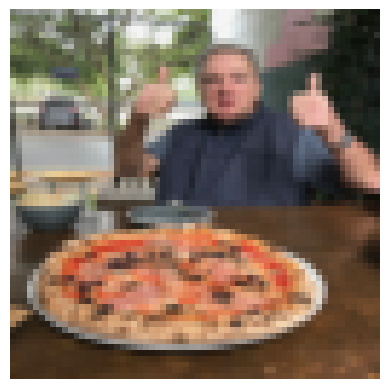

In [ ]:
from torchvision.transforms import v2

custom_image = custom_image_uint8.type(torch.float32).to(device) / 255. # to get value between 0 and 1
plt.imshow(custom_image.permute(1,2,0).cpu())
plt.axis(False)

resize_transform = v2.Compose([
    v2.Resize(size=(64, 64))])

custom_image_transfromed = resize_transform(custom_image)

print(custom_image_transfromed.shape)
print(custom_image_transfromed.dtype)

plt.imshow(custom_image_transfromed.permute(1,2,0).cpu())
plt.axis(False)

In [ ]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transfromed.unsqueeze(dim=0)) # we need a batch size for the image
  label = class_names[torch.softmax(custom_image_pred, dim=1).argmax(dim=1)]

  print(label)

pizza


### 9.3 Putting custom image prediction together

Ideal outcome:

A function where we pass an image path to and have the model predict on that image and plot the image + prediction

<bound method Module.cpu of TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10816, out_features=3, bias=True)
  )
)>
tensor([[ 0.1919, -0.3278, -0.6085]], device='cuda:0')


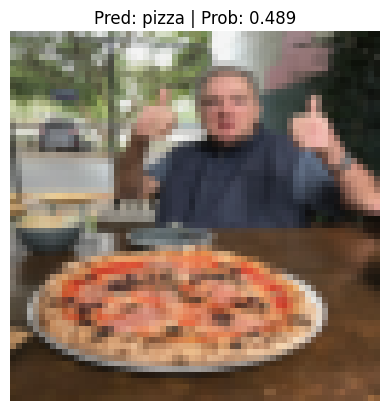

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
  """Makes a prediction on a target image and plots the image with its prediction."""
  custom_image_uint8 = torchvision.io.read_image(custom_image_path)
  print(model.cpu)
  custom_image = custom_image_uint8.type(torch.float32).to(device) / 255. # to get value between 0 and 1
  if transform:
    custom_image = transform(custom_image)

  model.to(device)

  model.eval()
  with torch.inference_mode():
    custom_image_pred = model(custom_image.unsqueeze(dim=0)) # we need a batch size for the image
    print(custom_image_pred)
    custom_image_prob = torch.softmax(custom_image_pred, dim=1)
    custom_image_label = custom_image_prob.argmax(dim=1)

    plt.imshow(custom_image.squeeze().permute(1, 2, 0).cpu()) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[custom_image_label.cpu()]} | Prob: {custom_image_prob.max().cpu():.3f}"
    else:
        title = f"Pred: {custom_image_pred} | Prob: {custom_image_prob.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=resize_transform,
                    device=device)

## Exercises

In [ ]:
model_2 = TinyVGG(
    input_shape=3, # number of color channel
    hidden_units=256,
    output_shape=len(train_data_simple.classes)
)

torch.manual_seed(42)

NUM_EPOCHS = 20

start_time = timer()
model_2_results = train(
    model=model_2,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer= torch.optim.Adam(model_2.parameters(),
                                lr=0.001),
    accuracy_fn=accuracy_fn,
    epochs=NUM_EPOCHS,
    device=device
)
end_time = timer()

print(f'Total training time: {end_time-start_time:.3f} seconds')
print(model_2_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.6353 | Train acc: 23.83% | Test loss: 1.1175, Test acc: 26.04%
Epoch: 1 | Train loss: 1.0863 | Train acc: 42.58% | Test loss: 1.2038, Test acc: 26.04%
Epoch: 2 | Train loss: 1.1065 | Train acc: 42.58% | Test loss: 1.1111, Test acc: 26.04%
Epoch: 3 | Train loss: 1.0847 | Train acc: 34.77% | Test loss: 1.0915, Test acc: 25.00%
Epoch: 4 | Train loss: 0.9888 | Train acc: 52.73% | Test loss: 1.0238, Test acc: 41.29%
Epoch: 5 | Train loss: 1.0376 | Train acc: 49.22% | Test loss: 1.1409, Test acc: 49.43%
Epoch: 6 | Train loss: 0.9451 | Train acc: 59.38% | Test loss: 1.1074, Test acc: 33.24%
Epoch: 7 | Train loss: 0.9149 | Train acc: 67.19% | Test loss: 1.1156, Test acc: 33.14%
Epoch: 8 | Train loss: 0.9410 | Train acc: 52.34% | Test loss: 1.1160, Test acc: 51.52%
Epoch: 9 | Train loss: 0.8744 | Train acc: 65.62% | Test loss: 1.0001, Test acc: 35.23%
Epoch: 10 | Train loss: 0.8235 | Train acc: 66.41% | Test loss: 0.9636, Test acc: 38.26%
Epoch: 11 | Train loss: 0.7039 

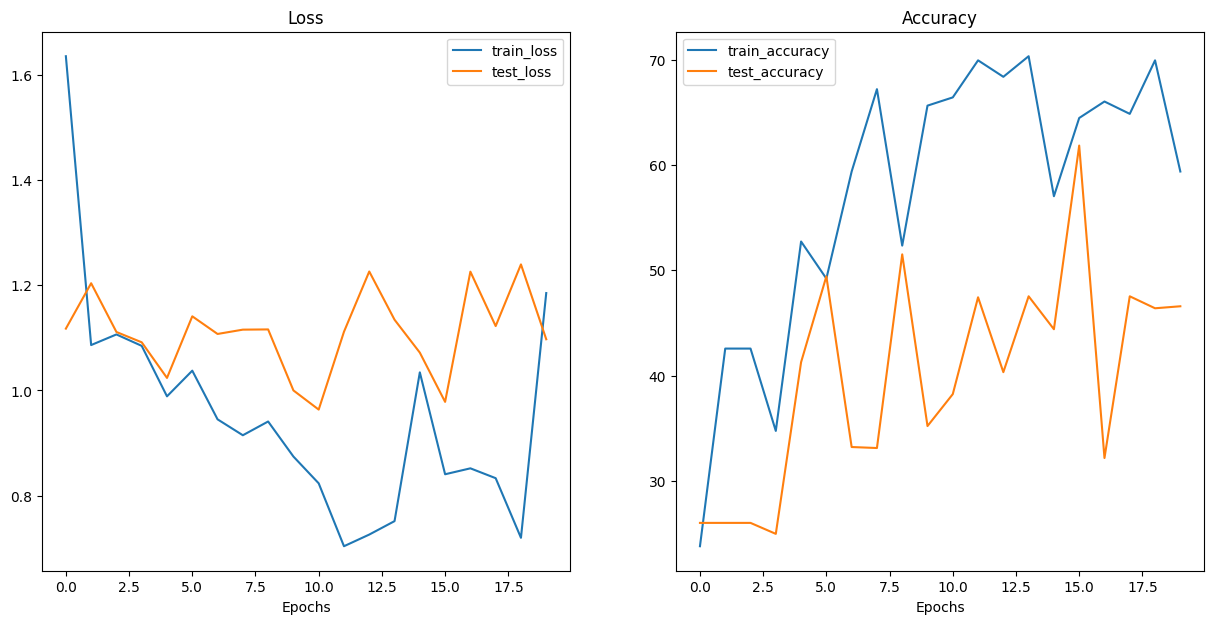

In [ ]:
plot_loss_curves(model_2_results)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.2799 | Train acc: 42.19% | Test loss: 1.2181, Test acc: 26.04%
Epoch: 1 | Train loss: 1.1331 | Train acc: 29.69% | Test loss: 1.0937, Test acc: 19.79%
Epoch: 2 | Train loss: 1.0878 | Train acc: 43.75% | Test loss: 1.0500, Test acc: 47.35%
Epoch: 3 | Train loss: 1.0077 | Train acc: 43.75% | Test loss: 1.0581, Test acc: 44.32%
Epoch: 4 | Train loss: 0.9845 | Train acc: 48.05% | Test loss: 2.0769, Test acc: 21.88%
Epoch: 5 | Train loss: 1.1741 | Train acc: 42.19% | Test loss: 1.1201, Test acc: 30.21%
Epoch: 6 | Train loss: 1.0710 | Train acc: 40.62% | Test loss: 1.0824, Test acc: 41.29%
Epoch: 7 | Train loss: 1.0425 | Train acc: 41.41% | Test loss: 1.0392, Test acc: 50.38%
Epoch: 8 | Train loss: 0.9761 | Train acc: 50.78% | Test loss: 1.0459, Test acc: 41.29%
Epoch: 9 | Train loss: 0.7552 | Train acc: 69.92% | Test loss: 1.1127, Test acc: 43.28%
Epoch: 10 | Train loss: 0.8338 | Train acc: 65.62% | Test loss: 1.1154, Test acc: 57.48%
Epoch: 11 | Train loss: 0.9119 

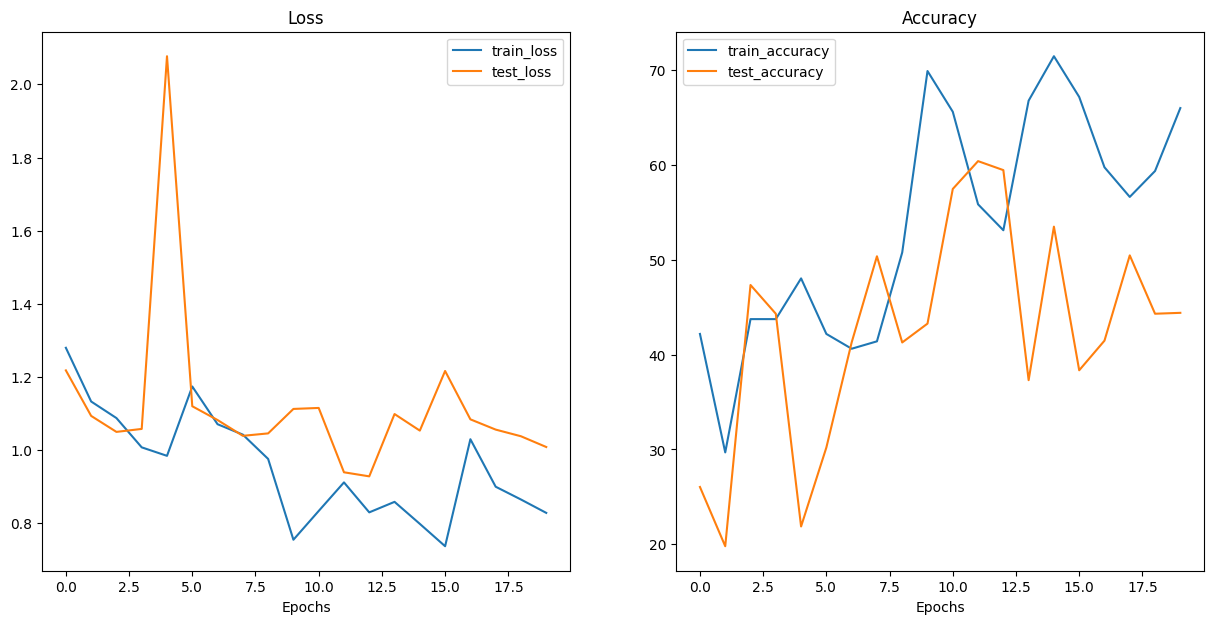

In [ ]:
# Let's try to increase image resolution and augmentation

train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_simple_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform, # for data
                                  target_transform=None) # for label

test_data_simple = datasets.ImageFolder(root=test_dir,
                                  transform=test_simple_transform, # for data
                                  target_transform=None)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

model_3 = TinyVGG(
    input_shape=3, # number of color channel
    hidden_units=256,
    output_shape=len(train_data_simple.classes)
)

NUM_EPOCHS = 20

start_time = timer()
model_3_results = train(
    model=model_3,
    train_dataloader=train_dataloader_simple,
    test_dataloader=test_dataloader_simple,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer= torch.optim.Adam(model_3.parameters(),
                                lr=0.001),
    accuracy_fn=accuracy_fn,
    epochs=NUM_EPOCHS,
    device=device
)
end_time = timer()

print(f'Total training time: {end_time-start_time:.3f} seconds')
print(model_3_results)
plot_loss_curves(model_3_results)

In [ ]:
# Let's get more train data
data_path = Path("drive/MyDrive/colab_copilot_data/04/data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

if image_path.is_dir():
  print(f"{image_path} already exists, skipping download")
else:
  print(f"Creating directory {image_path}")
  image_path.mkdir(parents=True, exist_ok=True)

  with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

  with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping file")
    zip_ref.extractall(image_path)

drive/MyDrive/colab_copilot_data/04/data/pizza_steak_sushi_20_percent already exists, skipping download


In [ ]:
# Create a convolutional neural network
class TinyVGGV2(nn.Module):
  """
    Model architecture that replicates the TinyVGG
    model from CNN explainer website
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape, # 2d because we have height and width
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.dummy_tensor = torch.randn(1, input_shape, 256, 256)
    self.features_out = self.conv_block_2(self.conv_block_1(self.dummy_tensor))
    self.flattened_size = self.features_out.numel()

    print(f"Computed Flattened Size: {self.flattened_size}")
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=self.flattened_size, # Pass a tensor through the cnn and use print to find out the shape of 7*7
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f'Output shape of cov_block_1: {x.shape}')
    x = self.conv_block_2(x)
    # print(f'Output shape of cov_block_2: {x.shape}')
    x = self.classifier(x)
    # print(f'Output shape of classifier: {x.shape}')
    return x

450 150
torch.Size([3, 256, 256])
Computed Flattened Size: 119072


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0876 | Train acc: 39.79% | Test loss: 1.0624, Test acc: 34.38%
Epoch: 1 | Train loss: 0.9785 | Train acc: 48.75% | Test loss: 0.9077, Test acc: 51.25%
Epoch: 2 | Train loss: 0.9830 | Train acc: 49.79% | Test loss: 0.9147, Test acc: 59.26%
Epoch: 3 | Train loss: 0.9438 | Train acc: 54.38% | Test loss: 0.8721, Test acc: 62.61%
Epoch: 4 | Train loss: 0.8458 | Train acc: 61.46% | Test loss: 0.8672, Test acc: 61.93%
Epoch: 5 | Train loss: 0.9292 | Train acc: 53.96% | Test loss: 0.8542, Test acc: 63.12%
Epoch: 6 | Train loss: 0.7782 | Train acc: 67.50% | Test loss: 0.8488, Test acc: 63.52%
Epoch: 7 | Train loss: 0.8026 | Train acc: 64.17% | Test loss: 0.8550, Test acc: 63.86%
Epoch: 8 | Train loss: 0.7880 | Train acc: 64.58% | Test loss: 0.8527, Test acc: 64.20%
Epoch: 9 | Train loss: 0.8361 | Train acc: 63.96% | Test loss: 0.9131, Test acc: 62.10%
Epoch: 10 | Train loss: 0.7757 | Train acc: 68.54% | Test loss: 0.8286, Test acc: 60.97%
Epoch: 11 | Train loss: 0.8045 

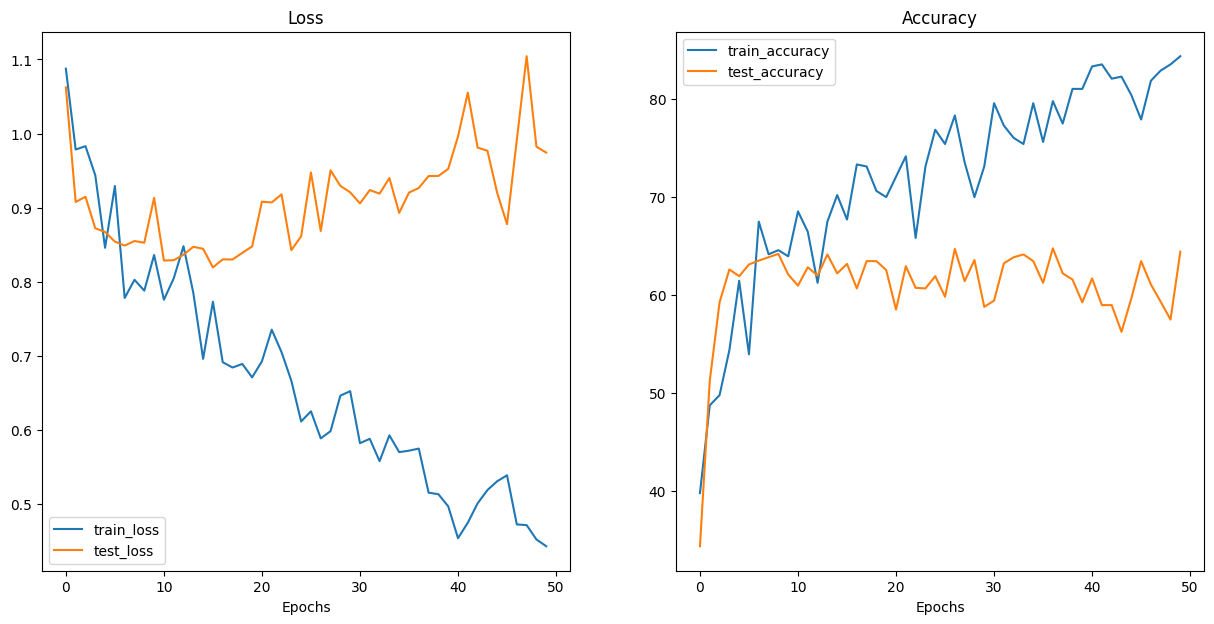

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.TrivialAugmentWide(num_magnitude_bins=15),
    transforms.ToTensor(),
    # Standard ImageNet normalization (works well for most RGB images)
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

test_simple_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform, # for data
                                  target_transform=None) # for label

test_data_simple = datasets.ImageFolder(root=test_dir,
                                  transform=test_simple_transform, # for data
                                  target_transform=None)

print(len(train_data_augmented), len(test_data_simple))
print(train_data_augmented[0][0].shape)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

model_4 = TinyVGGV2(
    input_shape=3, # number of color channel
    hidden_units=32,
    output_shape=len(train_data_simple.classes)
)

NUM_EPOCHS = 50

start_time = timer()
model_4_results = train(
    model=model_4,
    train_dataloader=train_dataloader_augmented,
    test_dataloader=test_dataloader_simple,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer= torch.optim.Adam(model_4.parameters(),
                                lr=0.0001),
    accuracy_fn=accuracy_fn,
    epochs=NUM_EPOCHS,
    device=device
)
end_time = timer()

print(f'Total training time: {end_time-start_time:.3f} seconds')
print(model_4_results)
plot_loss_curves(model_4_results)